In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

c:\Users\firda\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [153]:
data = pd.read_excel(r"C:\Users\firda\OneDrive\Študijný materiál\VŠ\2024 LS 2.rocnik\NeuronoveSiete\Zadanie\Spracovanie dat\upravene_data.xlsx", sheet_name="Sheet1")

In [92]:
data = pd.read_excel(r"C:\Users\firda\OneDrive\Študijný materiál\VŠ\2024 LS 2.rocnik\NeuronoveSiete\Zadanie\nove data\dataset_1SP_4r.xlsx", sheet_name="Sheet1")

In [12]:
data

,Sinter.EO1.O2.Comb.Gas.O2Content.%,Sinter.EO1.QSPAL.Comb.Gas.Volume.m3/hr,Sinter.EO1.TZL_P.Comb.Gas.TSPContent.mg/m3,Sinter.MB1.AUTO.MixingDrumNo1.AutomaticControl,Sinter.MB1.MS.Scales.Flow.Total.t/hr,Sinter.MB1.MS22.CokeScales.Flow.t/hr,Sinter.MB1.Q1.MixingDrumNo1.Water.Flow.m3/hr,Sinter.MB1.WK1.MixingDrumNo1.Humidity.%,Sinter.SP1.FuelChange.%,Sinter.SP1.PS1.WindBoxNo1.Vacuum.kPa,...,Sinter.SP.Fe.Content.Average.%,Sinter.SP.FeO.Content.Average.%,Sinter.SP.MgO.Content.Average.%,Sinter.SP.Mn.Content.Average.%,Sinter.SP.P.Content.Average.%,Sinter.SP.P2.Content.Average,Sinter.SP.S.Content.Average.%,Sinter.SP.SiO2.Content.Average.%,Sinter.SP.Zn.Content.Average.%,Rozsev5mm
0,18.250492,689.031586,128.623250,1.0,92.395000,1.410808,2.857267,7.299833,3.21,-4.258733,...,54.619999,6.78,2.38,0.63,0.045,1.32,0.015,7.74,0.014,10.000000
1,17.908492,668.094070,55.209067,1.0,124.684634,2.534675,4.188550,5.941692,3.22,-4.796542,...,53.279999,8.78,2.34,0.61,0.047,1.42,0.026,8.16,0.016,11.040000
2,17.960808,660.080982,106.115717,1.0,199.740409,3.375942,6.296883,7.745525,3.12,-4.874158,...,53.279999,5.66,2.42,0.70,0.039,1.53,0.043,7.75,0.020,10.670000
3,18.151758,590.895209,87.906391,1.0,105.989692,1.966742,3.243742,7.460700,3.12,-3.841817,...,53.689999,5.76,2.26,0.71,0.038,1.55,0.044,7.54,0.021,9.490000
4,18.245967,677.744265,112.744958,0.0,208.096024,1.928150,5.792675,7.969850,3.12,-4.415583,...,53.759998,7.09,2.38,0.72,0.038,1.48,0.039,7.80,0.023,16.469999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2440,20.760150,315.074359,134.197574,0.0,0.000000,0.000000,-0.012900,3.976150,2.59,-0.712925,...,53.820000,7.99,1.92,0.44,0.032,1.63,0.051,7.02,0.013,9.440000
2441,19.233725,405.407117,27.919942,0.0,147.264767,0.791550,4.037808,4.433633,2.59,-2.166058,...,54.090000,6.37,1.87,0.44,0.028,1.88,0.054,6.72,0.007,10.420000
2442,19.160317,409.019417,28.841592,0.0,147.202717,2.110517,4.188592,4.598633,2.95,-2.451025,...,52.849998,6.34,1.94,0.54,0.026,1.74,0.043,7.44,0.006,8.700000
2443,19.081075,397.061558,32.334183,0.0,148.030084,2.318875,3.625742,4.472500,3.09,-2.128692,...,54.000000,6.91,1.84,0.43,0.024,1.65,0.042,7.19,0.006,10.100000


In [93]:
X = data.drop(columns=["Rozsev5mm"])
y = data["Rozsev5mm"]
#X = data.drop(columns=["Rozsev 0-5"])
#y = data["Rozsev 0-5"]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=1234, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1234, shuffle=True)

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32) 
y_val = torch.tensor(y_val, dtype=torch.float32) 
y_test = torch.tensor(y_test, dtype=torch.float32)

train = TensorDataset(X_train, y_train)
test = TensorDataset(X_test, y_test)
val = TensorDataset(X_val, y_val)

# Vytvorenie dataloaders pre trénovaciu a testovaciu sadu
train_loader = DataLoader(train, batch_size=64, shuffle=False)
test_loader = DataLoader(test, batch_size=64, shuffle=False)
validation_loader = DataLoader(val, batch_size=64, shuffle=False)

In [14]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, dropout = 0.4):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim 
        self.layer_dim = layer_dim 
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)

        self.fc = nn.Linear(hidden_dim, 32)  
        self.fc1 = nn.Linear(32, 1)  
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

         # Forward propagation through LSTM layer
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.dropout(out)
        # Index hidden state of last time step
        out = nn.functional.relu(self.fc(out))
        out = self.dropout(out)
        out = self.fc1(out[:, -1, :])
        return out

In [94]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, dropout):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim 
        self.layer_dim = layer_dim 
        self.dropout = dropout 
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, dropout = dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 64)
        self.fc1 = nn.Linear(64, 32)  
        self.fc2 = nn.Linear(32, 1)  
        self.dropoutl = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

         # Forward propagation through LSTM layer
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.dropoutl(out)

        out = nn.functional.relu(self.fc(out[:, -1, :]))
        #out = self.dropoutl(out)
        out = self.fc1(out)
        #out = self.dropoutl(out)
        out = self.fc2(out)
        return out

In [170]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, dropout=0.4):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim  # Hidden dimensions
        self.layer_dim = layer_dim  # Number of hidden layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  # Fully connected layer

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation through LSTM layer
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.dropout(out)
        # Reshape the output to fit into the fully connected layer
        out = self.fc(out[:, -1, :]) # Selecting the output from the last time step
        return out

In [95]:
num_epochs = 300
input_dim = len(X.columns) 
hidden_dim = 75
layer_dim = 3

model = LSTMModel(input_dim, hidden_dim, layer_dim, dropout=0.3)

error = nn.MSELoss()
learning_rate = 0.001
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)

Iteration: 100. Loss: 100.41619873046875
Validation Loss: 102.40468443576906
Iteration: 200. Loss: 109.25074768066406
Validation Loss: 102.25333504326012
Iteration: 300. Loss: 112.1437759399414
Validation Loss: 102.07385549103532
Iteration: 400. Loss: 91.05718231201172
Validation Loss: 101.86576612508914
Iteration: 500. Loss: 101.48155212402344
Validation Loss: 101.62666670048269
Iteration: 600. Loss: 98.30925750732422
Validation Loss: 101.35224367812154
Iteration: 700. Loss: 110.8577651977539
Validation Loss: 101.03348354162897
Iteration: 800. Loss: 97.05500793457031
Validation Loss: 100.65359193557615
Iteration: 900. Loss: 101.13455200195312
Validation Loss: 100.1873141296553
Iteration: 1000. Loss: 109.64461517333984
Validation Loss: 99.58285065113037
Iteration: 1100. Loss: 106.62165069580078
Validation Loss: 98.74095941694296
Iteration: 1200. Loss: 99.72205352783203
Validation Loss: 97.45830999473135
Iteration: 1300. Loss: 112.73468017578125
Validation Loss: 95.2956617599612
Iterati

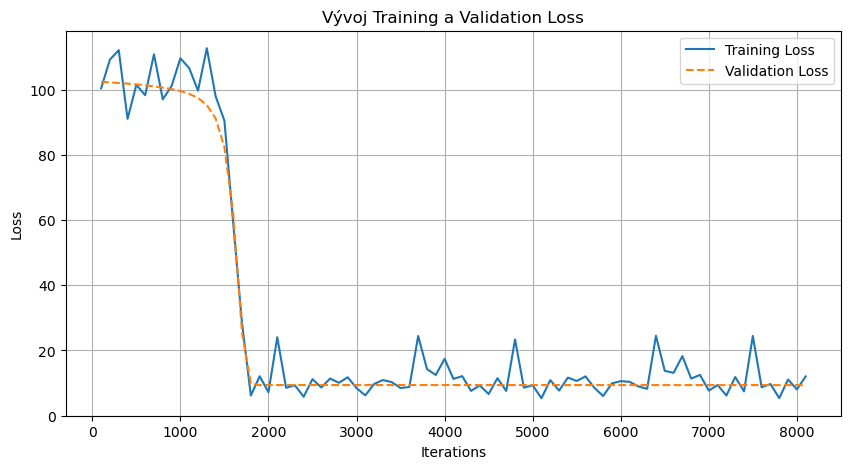

In [96]:
loss_list = []
iteration_list = []
validation_loss_list = [] 
iterations = 0
for epoch in range(num_epochs):
    model.train() 
    for i, (data, labels) in enumerate(train_loader):
       
        data = data.view(-1, 1, input_dim).requires_grad_()
        
        optimizer.zero_grad()
        
        outputs = model(data)
        
        loss = error(outputs.squeeze(), labels)
        
        loss.backward()
        
        optimizer.step()
        iterations += 1

        
        if iterations % 100 == 0:
            loss_list.append(loss.item())
            iteration_list.append(iterations)

            # Výpis straty
            print('Iteration: {}. Loss: {}'.format(iterations, loss.item()))

            model.eval()  
            validation_loss = 0.0
            for data_val, labels_val in validation_loader:
                data_val = data_val.view(-1, 1, input_dim)
                outputs_val = model(data_val)
                loss_val = error(outputs_val.squeeze(), labels_val)
                validation_loss += loss_val.item() * data_val.size(0)  

            validation_loss /= len(validation_loader.dataset)  
            validation_loss_list.append(validation_loss)
            print('Validation Loss: {}'.format(validation_loss))

# po skončení všetkých epoch
plt.figure(figsize=(10, 5))
plt.plot(iteration_list, loss_list, label='Training Loss')
plt.plot(iteration_list, validation_loss_list, label='Validation Loss', linestyle='--')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Vývoj Training a Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

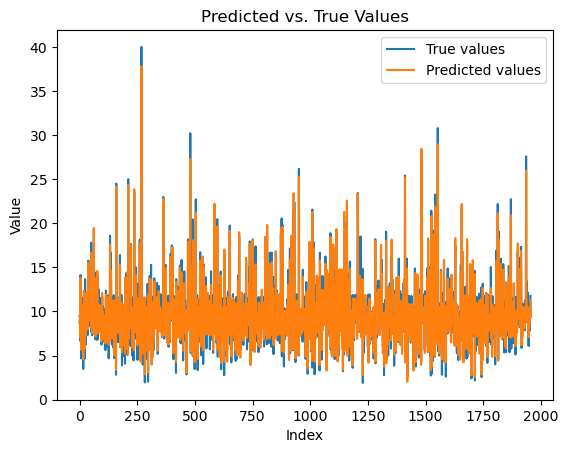

In [78]:
model.eval()

predicted_values = []
true_values = []

with torch.no_grad():
    for data, labels in train_loader:
        data = data.view(-1, 1, input_dim)
        outputs = model(data)
        predicted_values.extend(outputs.cpu().numpy())
        true_values.extend(labels.cpu().numpy())

plt.plot(true_values, label="True values")
plt.plot(predicted_values, label="Predicted values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Predicted vs. True Values")
plt.legend()
plt.show()

In [79]:
model.eval()

with torch.no_grad():
    for data, labels in train_loader:
        outputs = model(data.view(-1, 1, input_dim))
        
        for i in range(len(outputs)):
            print("Predikovaná hodnota:", outputs[i].item(), "| Skutočná hodnota:", labels[i].item())

Predikovaná hodnota: 8.725488662719727 | Skutočná hodnota: 9.520000457763672
Predikovaná hodnota: 9.038993835449219 | Skutočná hodnota: 9.489999771118164
Predikovaná hodnota: 8.475537300109863 | Skutočná hodnota: 7.579999923706055
Predikovaná hodnota: 7.0604376792907715 | Skutočná hodnota: 6.670000076293945
Predikovaná hodnota: 13.826396942138672 | Skutočná hodnota: 14.130000114440918
Predikovaná hodnota: 7.1903486251831055 | Skutočná hodnota: 7.190000057220459
Predikovaná hodnota: 8.747817993164062 | Skutočná hodnota: 9.479999542236328
Predikovaná hodnota: 5.654853820800781 | Skutočná hodnota: 4.670000076293945
Predikovaná hodnota: 8.850793838500977 | Skutočná hodnota: 8.40999984741211
Predikovaná hodnota: 10.693511962890625 | Skutočná hodnota: 11.59000015258789
Predikovaná hodnota: 8.391020774841309 | Skutočná hodnota: 9.199999809265137
Predikovaná hodnota: 8.508109092712402 | Skutočná hodnota: 9.680000305175781
Predikovaná hodnota: 7.6968092918396 | Skutočná hodnota: 7.5900001525878

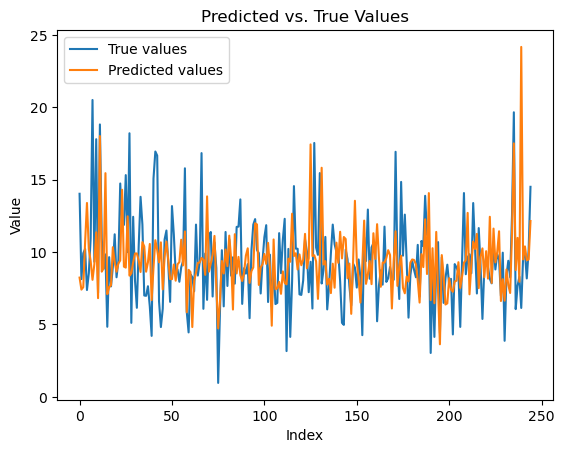

In [80]:
model.eval()

predicted_values = []
true_values = []

with torch.no_grad():
    for data, labels in test_loader:
        data = data.view(-1, 1, input_dim)
        outputs = model(data)
        predicted_values.extend(outputs.cpu().numpy())
        true_values.extend(labels.cpu().numpy())

plt.plot(true_values, label="True values")
plt.plot(predicted_values, label="Predicted values")
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Predicted vs. True Values")
plt.legend()
plt.show()

In [81]:
model.eval()

with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data.view(-1, 1, input_dim))
        
        for i in range(len(outputs)):
            print("Predikovaná hodnota:", outputs[i].item(), "| Skutočná hodnota:", labels[i].item())

Predikovaná hodnota: 8.237558364868164 | Skutočná hodnota: 14.029999732971191
Predikovaná hodnota: 7.407860279083252 | Skutočná hodnota: 8.130000114440918
Predikovaná hodnota: 7.574492931365967 | Skutočná hodnota: 9.920000076293945
Predikovaná hodnota: 10.70341682434082 | Skutočná hodnota: 10.220000267028809
Predikovaná hodnota: 13.394540786743164 | Skutočná hodnota: 7.380000114440918
Predikovaná hodnota: 10.1995849609375 | Skutočná hodnota: 8.539999961853027
Predikovaná hodnota: 9.370357513427734 | Skutočná hodnota: 10.960000038146973
Predikovaná hodnota: 8.084173202514648 | Skutočná hodnota: 20.510000228881836
Predikovaná hodnota: 9.161827087402344 | Skutočná hodnota: 9.329999923706055
Predikovaná hodnota: 11.365866661071777 | Skutočná hodnota: 17.799999237060547
Predikovaná hodnota: 6.816039085388184 | Skutočná hodnota: 7.179999828338623
Predikovaná hodnota: 18.01716423034668 | Skutočná hodnota: 18.81999969482422
Predikovaná hodnota: 8.648231506347656 | Skutočná hodnota: 10.93000030